In [226]:
library(qvalue)
library(dplyr)
library(ggplot2)

In [227]:
filename2 = "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_neuroseq/data/data_processed/pool1_17_D52/qtl_analysis/eqtl_discovery_separated_by_treatment/input_files_untreated/celltype_DA/top_qtl_results_all.txt"
myfile2 = read.csv(filename2,sep="\t")
head(myfile2,2)

# myfile2$global_corr_p_value = p.adjust(myfile2$empirical_feature_p_value, method = "BH")
# nrow(myfile2[myfile2$global_corr_p_value < 0.05,])
myfile2$q_value = qvalue(myfile2$empirical_feature_p_value)$qvalues
length(unique(myfile2[myfile2$q_value < 0.05,'feature_id']))

snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,n_samples,n_e_samples,alpha_param,beta_param,snp_chromosome,snp_position,assessed_allele,call_rate,maf,hwe_p,feature_id
5_6605829_G_T,4.526650e-04,0.2143554,0.06111680,0.3137267,5,6599352,6633404,175,175,0.5234127,210.2815,5,6605829,T,1,0.4657143,1.000000,ENSG00000037474
5_7344998_A_T,3.154604e-05,0.3821088,0.09180874,0.1073642,5,7396321,7830194,175,175,0.4945272,274.1518,5,7344998,T,1,0.1200000,0.717637,ENSG00000078295


[1] 1024

In [228]:
annos_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/Ensemble_75_Gene_Structures_Exon_Info.txt"
annos = read.csv(annos_file, sep = "\t")
head(annos,2)

Ensembl.Gene.ID,Ensembl.Transcript.ID,Ensembl.Protein.ID,Chromosome.Name,Gene.Start..bp.,Gene.End..bp.,Strand,Transcript.Start..bp.,Transcript.End..bp.,X5..UTR.Start,X5..UTR.End,X3..UTR.Start,X3..UTR.End,Exon.Chr.Start..bp.,Exon.Chr.End..bp.,Constitutive.Exon,Exon.Rank.in.Transcript,Ensembl.Exon.ID
ENSG00000261657,ENST00000566782,ENSP00000456546,HG991_PATCH,66119285,66465398,1,66119285,66456619,66119285,66119659,NA,NA,66119285,66119659,0,1,ENSE00002619671
ENSG00000261657,ENST00000566782,ENSP00000456546,HG991_PATCH,66119285,66465398,1,66119285,66456619,66298434,66298786,NA,NA,66298434,66298819,0,2,ENSE00002619173


In [229]:
annos1 = distinct(annos[,c("Ensembl.Gene.ID","Gene.Start..bp.","Gene.End..bp.","Strand")])
colnames(annos1) = c("feature_id","feature_start","feature_end","strand")
head(annos1,2)

feature_id,feature_start,feature_end,strand
ENSG00000261657,66119285,66465398,1
ENSG00000223116,23551994,23552136,-1


In [230]:
myfile2 = myfile2[myfile2$q_value < 0.05,]

In [302]:
nrow(myfile2)
myfile3 = left_join(myfile2,annos1)
nrow(myfile3)
head(myfile3,2)

[1] 1027

Joining, by = c("feature_start", "feature_end", "feature_id")
Warning message:
“Column `feature_id` joining factors with different levels, coercing to character vector”

[1] 1027

snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,n_samples,n_e_samples,...,beta_param,snp_chromosome,snp_position,assessed_allele,call_rate,maf,hwe_p,feature_id,q_value,strand
9_94639418_T_A,1.322391e-08,-0.8341359,0.14677361,0.0004332491,9,94794281,94877666,175,175,...,72.68438,9,94639418,A,1,0.05428571,1.0000000,ENSG00000090054,0.004995807,-1
9_91743809_C_T,6.101031e-09,-0.5494673,0.09450819,0.0004317183,9,91926113,91931618,175,175,...,57.82682,9,91743809,T,1,0.07142857,0.6024874,ENSG00000123975,0.004986263,1


In [303]:
myfile3$feature_length = myfile3$feature_end - myfile3$feature_start
myfile3$TSS = myfile3$feature_start
myfile3[myfile3$strand == -1,"TSS"] = myfile3[myfile3$strand == -1,"feature_end"]
myfile3$TES = myfile3$feature_end
myfile3[myfile3$strand == -1,"TES"] = myfile3[myfile3$strand == -1,"feature_start"]
head(myfile3[,c("feature_length","feature_start","feature_end","strand","TSS","TES","snp_position")])

feature_length,feature_start,feature_end,strand,TSS,TES,snp_position
83385,94794281,94877666,-1,94877666,94794281,94639418
5505,91926113,91931618,1,91926113,91931618,91743809
148098,93976097,94124195,-1,94124195,93976097,93981649
41618,75784850,75826468,1,75784850,75826468,75836087
90108,77157368,77247476,1,77157368,77247476,77128577
16340,420773,437113,-1,437113,420773,421723


In [304]:
df = myfile3
df$snp_location = "downstream"
#
df[(df$snp_position > df$feature_start &  df$snp_position < df$feature_end) & 
                (abs(df$snp_position-df$TSS) < abs(df$snp_position-df$TES)),"snp_location"] = "gene_body_TSS_closest"
df[(df$snp_position > df$feature_start &  df$snp_position < df$feature_end) & 
                (abs(df$snp_position-df$TSS) > abs(df$snp_position-df$TES)),"snp_location"] = "gene_body_TES_closest"
#
df[(df$snp_position < df$feature_start & df$strand == 1) | (df$snp_position > df$feature_end & df$strand == -1),"snp_location"] = "upstream"
myfile3 = df
head(myfile3[,c("feature_length","feature_start","feature_end","strand","TSS","TES","snp_position","snp_location")])

feature_length,feature_start,feature_end,strand,TSS,TES,snp_position,snp_location
83385,94794281,94877666,-1,94877666,94794281,94639418,downstream
5505,91926113,91931618,1,91926113,91931618,91743809,upstream
148098,93976097,94124195,-1,94124195,93976097,93981649,gene_body_TES_closest
41618,75784850,75826468,1,75784850,75826468,75836087,downstream
90108,77157368,77247476,1,77157368,77247476,77128577,upstream
16340,420773,437113,-1,437113,420773,421723,gene_body_TES_closest


In [305]:
table(df$snp_location)


           downstream gene_body_TES_closest gene_body_TSS_closest 
                  290                   214                   208 
             upstream 
                  315 

In [306]:
208+215
290+315
(208+215)/(208+215+290+315)
(290+315)/(208+215+290+315)

[1] 423

[1] 605

[1] 0.4114786

[1] 0.5885214

In [307]:
df_bars = data.frame(table(df$snp_location))
df_bars$order = c(4,3,2,1)

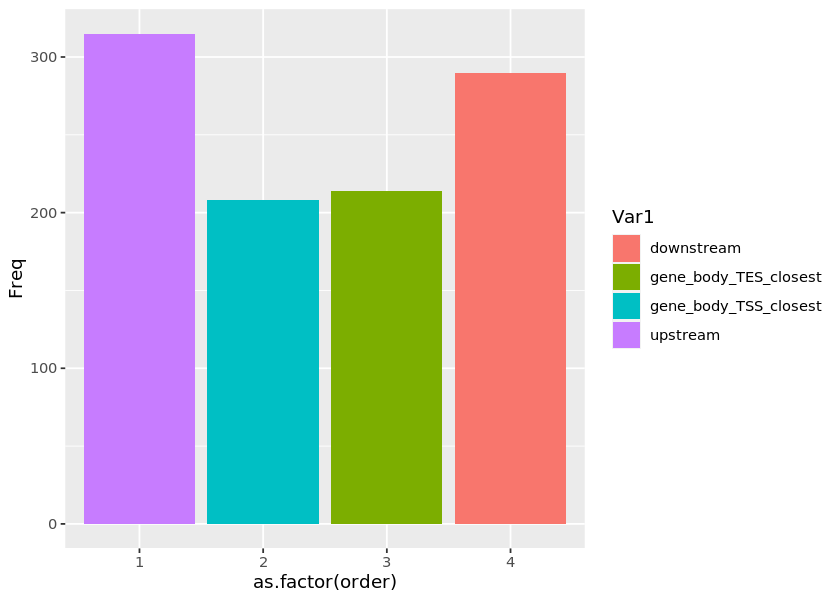

In [308]:
ggplot(df_bars, aes(x = as.factor(order), y = Freq, fill = Var1)) + geom_bar(stat="identity")

In [309]:
df = myfile3
df$inside_dist = 0
df[df$snp_location == "gene_body_TSS_closest" & df$strand == 1,"inside_dist"] = (df[df$snp_location == "gene_body_TSS_closest" & df$strand == 1,"snp_position"] - df[df$snp_location == "gene_body_TSS_closest" & df$strand == 1,"TSS"])/df[df$snp_location == "gene_body_TSS_closest" & df$strand == 1,"feature_length"]
df[df$snp_location == "gene_body_TES_closest" & df$strand == 1,"inside_dist"] = (df[df$snp_location == "gene_body_TES_closest" & df$strand == 1,"snp_position"] - df[df$snp_location == "gene_body_TES_closest" & df$strand == 1,"TSS"])/df[df$snp_location == "gene_body_TES_closest" & df$strand == 1,"feature_length"]
df[df$snp_location == "gene_body_TSS_closest" & df$strand == -1,"inside_dist"] = (df[df$snp_location == "gene_body_TSS_closest" & df$strand == -1,"TSS"] - df[df$snp_location == "gene_body_TSS_closest" & df$strand == -1,"snp_position"])/df[df$snp_location == "gene_body_TSS_closest" & df$strand == -1,"feature_length"]
df[df$snp_location == "gene_body_TES_closest" & df$strand == -1,"inside_dist"] = (df[df$snp_location == "gene_body_TES_closest" & df$strand == -1,"TSS"] - df[df$snp_location == "gene_body_TES_closest" & df$strand == -1,"snp_position"])/df[df$snp_location == "gene_body_TES_closest" & df$strand == -1,"feature_length"]
myfile3 = df
head(myfile3[,c("feature_length","feature_start","feature_end","strand","TSS","TES",
                "snp_position","snp_location","inside_dist")])


feature_length,feature_start,feature_end,strand,TSS,TES,snp_position,snp_location,inside_dist
83385,94794281,94877666,-1,94877666,94794281,94639418,downstream,0.0000000
5505,91926113,91931618,1,91926113,91931618,91743809,upstream,0.0000000
148098,93976097,94124195,-1,94124195,93976097,93981649,gene_body_TES_closest,0.9625113
41618,75784850,75826468,1,75784850,75826468,75836087,downstream,0.0000000
90108,77157368,77247476,1,77157368,77247476,77128577,upstream,0.0000000
16340,420773,437113,-1,437113,420773,421723,gene_body_TES_closest,0.9418605


In [331]:
df[df$inside_dist <= 0.5, "dist_pct"] = floor(round(df[df$inside_dist <= 0.5, "inside_dist"], digits = 2)*10)*10
df[df$inside_dist > 0.5, "dist_pct"] = ceiling(round(df[df$inside_dist > 0.5, "inside_dist"], digits = 2)*10)*10
myfile3 = df
head(myfile3[myfile3$inside_dist !=0,c("feature_length","feature_start","feature_end","strand","TSS","TES",
                "snp_position","snp_location","inside_dist","dist_pct")])

,feature_length,feature_start,feature_end,strand,TSS,TES,snp_position,snp_location,inside_dist,dist_pct
3,148098,93976097,94124195,-1,94124195,93976097,93981649,gene_body_TES_closest,0.9625113,100
6,16340,420773,437113,-1,437113,420773,421723,gene_body_TES_closest,0.9418605,100
8,10661,451826,462487,1,451826,462487,457768,gene_body_TES_closest,0.5573586,60
9,99985,41992489,42092474,1,41992489,42092474,42037009,gene_body_TSS_closest,0.4452668,40
11,126029,47916159,48042188,1,47916159,48042188,48019626,gene_body_TES_closest,0.8209777,90
12,60716,9102640,9163356,1,9102640,9163356,9158317,gene_body_TES_closest,0.9170070,100


In [342]:
df[df$dist_pct > 0 & df$dist_pct < 50,"snp_dist_bin"] = paste0("TSS_closest_",df[df$dist_pct > 0 & df$dist_pct < 50,"dist_pct"])
df[df$dist_pct > 50,"snp_dist_bin"] = paste0("TES_closest_",100-df[df$dist_pct > 50,"dist_pct"])

myfile3 = df
head(myfile3[myfile3$inside_dist !=0,c("feature_length","feature_start","feature_end","strand","TSS","TES",
                "snp_position","snp_location","dist_pct","inside_dist","snp_dist_bin")])

,feature_length,feature_start,feature_end,strand,TSS,TES,snp_position,snp_location,dist_pct,inside_dist,snp_dist_bin
3,148098,93976097,94124195,-1,94124195,93976097,93981649,gene_body_TES_closest,100,0.9625113,TES_closest_0
6,16340,420773,437113,-1,437113,420773,421723,gene_body_TES_closest,100,0.9418605,TES_closest_0
8,10661,451826,462487,1,451826,462487,457768,gene_body_TES_closest,60,0.5573586,TES_closest_40
9,99985,41992489,42092474,1,41992489,42092474,42037009,gene_body_TSS_closest,40,0.4452668,TSS_closest_40
11,126029,47916159,48042188,1,47916159,48042188,48019626,gene_body_TES_closest,90,0.8209777,TES_closest_10
12,60716,9102640,9163356,1,9102640,9163356,9158317,gene_body_TES_closest,100,0.9170070,TES_closest_0


In [343]:
df$dist = 0
df[df$snp_location %in% c("upstream","downstream") & df$strand == 1,"dist"] = df[df$snp_location %in% c("upstream","downstream") & df$strand == 1,"snp_position"] - df[df$snp_location %in% c("upstream","downstream") & df$strand == 1,"TSS"]
df[df$snp_location %in% c("upstream","downstream") & df$strand == -1,"dist"] = df[df$snp_location %in% c("upstream","downstream") & df$strand == -1,"TSS"] - df[df$snp_location %in% c("upstream","downstream") & df$strand == -1,"snp_position"] 


In [344]:
myfile3 = df
head(myfile3[,c("feature_length","feature_start","feature_end","strand","TSS","TES",
                "snp_position","snp_location","snp_dist_bin","dist")])

feature_length,feature_start,feature_end,strand,TSS,TES,snp_position,snp_location,snp_dist_bin,dist
83385,94794281,94877666,-1,94877666,94794281,94639418,downstream,downstream_230,238248
5505,91926113,91931618,1,91926113,91931618,91743809,upstream,upstream_180,-182304
148098,93976097,94124195,-1,94124195,93976097,93981649,gene_body_TES_closest,TES_closest_0,0
41618,75784850,75826468,1,75784850,75826468,75836087,downstream,downstream_50,51237
90108,77157368,77247476,1,77157368,77247476,77128577,upstream,upstream_20,-28791
16340,420773,437113,-1,437113,420773,421723,gene_body_TES_closest,TES_closest_0,0


In [345]:
df$dist_kb = floor(round(df$dist/1000)/10)*10
df[df$dist < 0,"dist_kb"] = ceiling(round(df[df$dist<0,"dist"]/1000)/10)*10
myfile3 = df
head(myfile3[,c("feature_length","feature_start","feature_end","strand","TSS","TES",
                "snp_position","snp_location","snp_dist_bin","dist","dist_kb")])

feature_length,feature_start,feature_end,strand,TSS,TES,snp_position,snp_location,snp_dist_bin,dist,dist_kb
83385,94794281,94877666,-1,94877666,94794281,94639418,downstream,downstream_230,238248,230
5505,91926113,91931618,1,91926113,91931618,91743809,upstream,upstream_180,-182304,-180
148098,93976097,94124195,-1,94124195,93976097,93981649,gene_body_TES_closest,TES_closest_0,0,0
41618,75784850,75826468,1,75784850,75826468,75836087,downstream,downstream_50,51237,50
90108,77157368,77247476,1,77157368,77247476,77128577,upstream,upstream_20,-28791,-20
16340,420773,437113,-1,437113,420773,421723,gene_body_TES_closest,TES_closest_0,0,0


In [355]:
df[df$dist > 0,"snp_dist_bin"] = paste0("downstream_",df[df$dist > 0,"dist_kb"])
df[df$dist_kb > 1000,"snp_dist_bin"] = "downstream_1000"
df[df$dist < 0,"snp_dist_bin"] = paste0("upstream_",abs(df[df$dist < 0,"dist_kb"]))
df[df$dist_kb < -500,"snp_dist_bin"] = "upstream_500"
myfile3 = df
head(myfile3[,c("feature_length","feature_start","feature_end","strand","TSS","TES",
                "snp_position","snp_location","snp_dist_bin","dist","dist_kb","dist_pct")])

feature_length,feature_start,feature_end,strand,TSS,TES,snp_position,snp_location,snp_dist_bin,dist,dist_kb,dist_pct
83385,94794281,94877666,-1,94877666,94794281,94639418,downstream,downstream_230,238248,230,0
5505,91926113,91931618,1,91926113,91931618,91743809,upstream,upstream_180,-182304,-180,0
148098,93976097,94124195,-1,94124195,93976097,93981649,gene_body_TES_closest,TES_closest_0,0,0,100
41618,75784850,75826468,1,75784850,75826468,75836087,downstream,downstream_50,51237,50,0
90108,77157368,77247476,1,77157368,77247476,77128577,upstream,upstream_20,-28791,-20,0
16340,420773,437113,-1,437113,420773,421723,gene_body_TES_closest,TES_closest_0,0,0,100


In [347]:
df_bars = data.frame(table(df$snp_dist_bin))
head(df_bars,2)

Var1,Freq
downstream_0,12
downstream_10,25


In [348]:
df_bars$bins = factor(df_bars$Var1, levels = c(paste0("upstream_",seq(500,0,-10)), 
                                               paste0("TSS_closest_",seq(0,50,10)),
                                               paste0("TES_closest_",seq(50,0,-10)),
                                              paste0("downstream_",seq(0,500,10))))

In [353]:
df_bars$bins

[1] downstream_0   downstream_10  downstream_100 downstream_110 downstream_120
 [6] downstream_130 downstream_140 downstream_150 downstream_160 downstream_170
[11] downstream_180 downstream_190 downstream_20  downstream_200 downstream_210
[16] downstream_220 downstream_230 downstream_240 downstream_250 downstream_270
[21] downstream_280 downstream_290 downstream_30  downstream_310 downstream_320
[26] downstream_330 downstream_340 downstream_350 downstream_360 downstream_380
[31] downstream_40  downstream_420 downstream_50  downstream_500 downstream_60 
[36] <NA>           downstream_70  downstream_80  downstream_90  TES_closest_0 
[41] TES_closest_10 TES_closest_20 TES_closest_30 TES_closest_40 TSS_closest_10
[46] TSS_closest_20 TSS_closest_30 TSS_closest_40 upstream_0     upstream_10   
[51] upstream_100   upstream_110   upstream_120   upstream_130   upstream_140  
[56] upstream_150   upstream_160   upstream_170   upstream_180   upstream_190  
[61] upstream_20    upstream_200   upstream_210   upstream_230   upstream_240  
[66] upstream_30    upstream_40    upstream_50    upstream_60    upstream_70   
[71] upstream_80    upstream_90   
114 Levels: upstream_500 upstream_490 upstream_480 upstream_470 ... downstream_500

In [351]:
df_bars[grep("upstream",df_bars$Var1),"category"] = "upstream"
df_bars[grep("closest",df_bars$Var1),"category"] = "gene_body"
# df_bars[grep("TES",df_bars$Var1),"category"] = "TES"
df_bars[grep("downstream",df_bars$Var1),"category"] = "downstream"

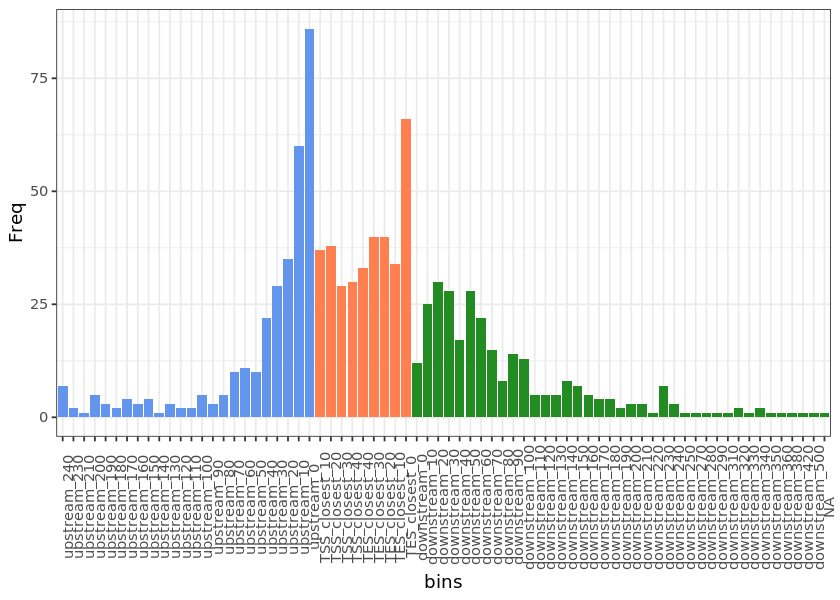

In [352]:
options(repr.plot.width=7, repr.plot.height=5)
ggplot(df_bars,
       aes(x = bins, y = Freq, fill = category)) + geom_bar(stat="identity") + theme_bw() + #ylim(c(0,100)) +
                            theme(legend.position = "none", axis.text.x = element_text(angle = 90)) +
                            scale_fill_manual(values = c("forestgreen","coral","cornflowerblue"))

In [362]:
nrow(df[df$dist_pct ==100,])

[1] 66